# 1. 클러스터링

In [1]:
import pandas as pd
import numpy as np
import math

#Visualizing
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'; plt.rcParams['axes.unicode_minus'] = False;
import seaborn as sns; #sns.set_style('whitegrid')

#Time Series Analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Clustering (+α)
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from minisom import MiniSom

#Modeling
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

#System
from ipywidgets import interact
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')


In [2]:
%matplotlib inline

## 경기도 클러스터링

In [15]:
data = pd.read_csv('전국가격지수.csv',index_col=0,encoding = 'cp949')
data


,2012-11-01,2012-12-01,2013-01-01,2013-02-01,2013-03-01,2013-04-01,2013-05-01,2013-06-01,2013-07-01,2013-08-01,...,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01
행정구역별,,,,,,,,,,,,,,,,,,,,,
전국,79.550364,79.327329,79.070446,78.892281,78.810276,78.955776,79.155173,79.215331,79.171207,79.065551,...,100,101.206901,102.567185,103.787444,105.016629,105.856641,106.203727,106.284037,106.262040,106.203239
서울특별시,74.420026,73.944356,73.481706,73.197123,73.107267,73.207601,73.380119,73.218260,72.829579,72.484054,...,100,100.811666,101.739971,102.657125,103.504915,104.121909,104.377172,104.382212,104.296694,104.223178
종로구,81.411253,81.407995,81.407995,81.407995,81.337486,81.313655,81.241809,80.970647,80.785417,80.626877,...,100,100.389827,101.181645,101.847102,102.756382,103.486567,103.652827,103.622889,103.377745,103.226713
중구,78.414443,77.935881,77.752858,77.792636,77.461336,77.494639,77.821790,78.022311,77.379109,76.693584,...,100,100.377028,101.003355,101.654878,102.575399,103.310747,103.462553,103.472794,103.389724,103.256276
용산구,83.910168,83.595174,83.303028,83.072056,82.765762,81.742557,81.448908,81.222130,80.879762,80.369736,...,100,100.636426,101.597995,102.569165,103.851584,105.020062,105.512652,105.608657,105.564649,105.530053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
거제시,136.113732,135.476256,133.940684,133.528081,133.827661,134.811680,135.697558,136.134536,136.698016,136.876444,...,100,100.674074,101.686253,102.396701,103.354363,104.139502,104.383379,104.566506,104.774017,105.179828
양산시,93.222472,93.253005,93.203437,93.104378,93.193020,93.658020,93.907752,93.895123,93.601929,93.411733,...,100,100.873089,102.134464,103.407351,104.601875,105.275329,105.622073,105.862045,106.084281,106.330705
제주특별자치도,80.052881,79.642685,79.431701,79.413448,79.378121,79.522831,79.482417,79.513583,79.504129,79.309511,...,100,101.898235,104.234108,105.610944,107.084376,108.223936,108.810295,109.174082,109.460336,109.690956


In [16]:
# 클러스터 돌리기 전 변수를 생성 
df = data.copy()


## 군집 개수 정하기

### 1. elbow method 

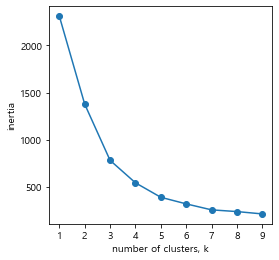

In [17]:
# 적절한 군집수 찾기 
# Inertia(군집 내 거리제곱합의 합) value (적정 군집수) 
ks = range(1,10) 
inertias = [] 
for k in ks: 
    model = TimeSeriesKMeans(n_clusters=k, metric="dtw",random_state = 2022)
    model.fit(df) 
    inertias.append(model.inertia_) 
    # Plot ks vs inertias 
plt.figure(figsize=(4, 4)) 
plt.plot(ks, inertias, '-o') 
plt.xlabel('number of clusters, k') 
plt.ylabel('inertia') 
plt.xticks(ks) 
plt.show()



### 2. silhouette 계수

In [18]:
import numpy as np
from sklearn.metrics import silhouette_samples
from sklearn.datasets import make_blobs
from matplotlib import cm

def plotSilhouette(X, y_km):
    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km, metric = 'euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i/n_clusters)

        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0,
                edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper)/2)
        y_ax_lower += len(c_silhouette_vals)

    silhoutte_avg = np.mean(silhouette_vals)
    plt.axvline(silhoutte_avg, color = 'red', linestyle='--')
    plt.yticks(yticks, cluster_labels+1)
    plt.ylabel('K')
    plt.xlabel('실루엣 계수')
    plt.show()


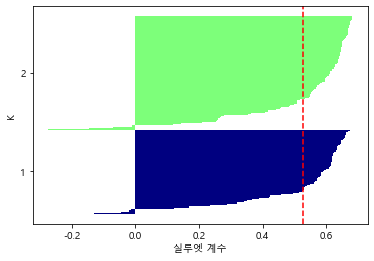

In [19]:
k= 2

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = TimeSeriesKMeans(n_clusters=k, metric="dtw",random_state = 2022)
y_km = km.fit_predict(df)
plotSilhouette(df, y_km)

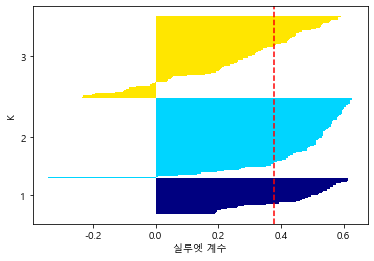

In [20]:
k= 3

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = TimeSeriesKMeans(n_clusters=k, metric="dtw",random_state = 2022)
y_km = km.fit_predict(df)
plotSilhouette(df, y_km)

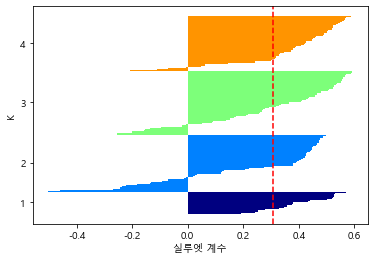

In [21]:
k= 4

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = TimeSeriesKMeans(n_clusters=k, metric="dtw",random_state = 2022)
y_km = km.fit_predict(df)
plotSilhouette(df, y_km)

## 클러스터별 저장

In [23]:
# K-Means 모델과 군집 예측값을 생성 
# 클러스터 모델 생성 파라미터는 원할 경우 추가 
model =  TimeSeriesKMeans(n_clusters=4, metric="dtw", random_state = 2022)
                     # 클러스터 갯수 
                     # , n_init=10 
                     # initial centroid를 몇번 샘플링한건지, 데이터가 많으면 많이 돌릴수록안정화된 결과가 나옴 
                     # , max_iter=500 # KMeans를 몇번 반복 수행할건지, K가 큰 경우 1000정도로 높여준다 
                     #random_state = 42 # , algorithm='auto' ) 
 # 생성한 모델로 데이터를 학습시킴 
model.fit(df) # unsupervised learning 
# 결과 값을 변수에 저장 
df['cluster'] = model.fit_predict(df)

In [49]:
df.to_csv('경기도_clustered.csv',encoding='utf-8')

In [24]:
df0= df.loc[df['cluster'] == 0]
df0

,2012-11-01,2012-12-01,2013-01-01,2013-02-01,2013-03-01,2013-04-01,2013-05-01,2013-06-01,2013-07-01,2013-08-01,...,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,cluster
행정구역별,,,,,,,,,,,,,,,,,,,,,
동구,117.883449,117.021161,116.431768,116.256713,116.071116,115.693526,115.282159,115.115800,114.912441,114.573184,...,102.325270,103.257443,104.304706,105.263780,105.977345,106.193829,106.148456,106.014136,105.793456,0
제천시,103.214231,104.346655,104.982382,104.685510,104.579701,104.826533,105.322409,105.313821,105.763770,106.174388,...,101.679698,103.535041,105.169757,107.856037,110.479918,111.634630,112.543332,112.789043,112.897506,0
보령시,104.298575,105.323216,105.535326,105.690512,105.858586,106.346125,106.754095,106.872502,107.253085,107.286533,...,101.798377,103.614687,104.809032,106.103725,107.692781,108.698107,109.321029,109.791457,110.130731,0
서산시,111.841464,111.759450,111.583796,111.567902,111.584450,112.170844,112.584632,112.832798,112.656296,112.616528,...,100.188651,100.867420,101.997848,103.048705,104.704682,105.844857,106.155719,106.635614,107.049259,0
당진시,105.183322,104.924211,104.876300,104.974924,105.076908,105.378550,105.659369,105.676112,105.882367,106.232499,...,100.356432,101.070787,102.112352,103.375041,104.509558,105.407115,105.653446,105.461198,105.394395,0
군산시,118.471700,118.095268,117.258329,116.982715,116.619271,116.606782,116.477660,116.101667,115.711964,115.532659,...,101.898084,103.577610,105.102864,106.385393,107.695571,108.233382,108.744305,109.027923,109.676975,0
경주시,92.043857,92.608277,93.318626,93.659310,94.311923,94.985067,96.150808,97.373883,98.906616,99.077347,...,100.434011,100.866485,101.116536,102.053159,102.724642,103.333437,103.743464,103.860239,104.166279,0
김천시,111.774222,111.774222,111.937099,111.937099,112.247417,112.394971,112.344373,112.306357,112.405267,112.442975,...,101.353224,102.493429,103.355980,104.239307,105.045248,105.586792,105.914312,106.018590,106.118180,0
안동시,102.292596,102.390197,102.216452,102.164654,102.738201,103.201865,103.314759,103.307032,104.890580,105.584867,...,101.356903,103.554421,104.631447,105.890703,106.685680,107.858915,108.505042,109.124201,109.453537,0


In [50]:
df0.to_csv('cluster0.csv',encoding='utf-8')

In [25]:
df1= df.loc[df['cluster'] == 1]
df1

,2012-11-01,2012-12-01,2013-01-01,2013-02-01,2013-03-01,2013-04-01,2013-05-01,2013-06-01,2013-07-01,2013-08-01,...,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,cluster
행정구역별,,,,,,,,,,,,,,,,,,,,,
서울특별시,74.420026,73.944356,73.481706,73.197123,73.107267,73.207601,73.380119,73.218260,72.829579,72.484054,...,100.811666,101.739971,102.657125,103.504915,104.121909,104.377172,104.382212,104.296694,104.223178,1
성동구,73.982731,73.176935,72.792778,72.426649,72.052161,71.712718,72.304678,72.496379,72.352790,72.174516,...,100.464196,101.010621,101.476967,101.880732,102.152632,102.249514,102.250870,102.207421,102.145049,1
노원구,74.247357,73.882399,73.513725,73.289984,73.190606,73.279750,73.333609,73.401812,73.163317,72.533748,...,101.490973,103.002571,104.170884,105.102551,105.685150,105.939536,105.818749,105.691129,105.582690,1
마포구,72.319260,72.203598,72.077690,72.064841,71.786343,71.628742,71.701514,71.879097,71.848379,71.446191,...,100.712648,101.571641,102.417601,103.644096,104.561819,104.756629,104.707002,104.596125,104.483251,1
양천구,73.287783,72.709957,72.062704,71.821898,71.725652,72.154700,72.192788,71.886116,71.284466,70.829804,...,100.520800,101.153077,101.708217,102.076957,102.404993,102.604649,102.627492,102.577898,102.556041,1
강서구,72.703714,72.237091,71.627226,71.133398,70.923227,71.256864,71.421174,71.292009,70.987878,70.744453,...,100.782049,101.826962,103.044855,103.959419,104.692653,105.005322,105.096206,105.036113,104.914394,1
영등포구,73.794757,73.470092,72.684335,72.382580,72.365291,72.755009,72.872015,72.476436,71.766810,71.460581,...,100.755763,101.565390,102.349995,103.027212,103.434332,103.602413,103.601928,103.532344,103.453587,1
동작구,70.484128,69.990706,69.529394,69.290355,69.245934,69.892213,70.332339,70.641651,70.223936,69.991196,...,100.939584,101.830164,102.853421,103.762641,104.430335,104.845951,104.883390,104.837375,104.732746,1
서초구,74.871601,74.390065,73.787377,73.562957,73.581078,73.593032,73.697354,73.541626,72.745188,72.227571,...,100.895309,101.895840,103.041206,104.190494,105.172167,105.738684,105.832631,105.827788,105.860287,1


In [51]:
df1.to_csv('cluster1.csv',encoding='utf-8')

In [26]:
df2= df.loc[df['cluster'] == 2]
df2

,2012-11-01,2012-12-01,2013-01-01,2013-02-01,2013-03-01,2013-04-01,2013-05-01,2013-06-01,2013-07-01,2013-08-01,...,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,cluster
행정구역별,,,,,,,,,,,,,,,,,,,,,
중구,94.587825,94.598911,94.438783,94.209485,94.196978,94.131973,94.157197,94.114133,94.050182,94.364816,...,100.628077,101.229351,101.472137,101.712936,101.980192,101.996737,101.911857,101.832935,101.730697,2
서구,93.154497,93.133800,93.105416,93.031718,93.021776,93.056948,93.114669,93.049241,92.971436,92.896058,...,100.377700,100.803540,101.238627,101.596159,102.196970,102.426706,102.400151,102.340609,102.314495,2
동구,89.405627,89.343233,89.317473,89.366159,89.366159,89.545050,89.813688,89.935818,89.924777,90.044243,...,100.734463,101.908596,102.096750,102.457040,103.086796,103.178622,103.003965,102.810318,102.764241,2
영도구,98.392853,97.917740,97.819040,97.812542,97.715115,97.655827,97.752564,97.642580,97.436226,97.338627,...,100.524122,101.066205,101.637923,102.269268,103.030769,103.402436,103.399447,103.371509,103.358145,2
북구,87.651144,87.308861,87.096696,87.120273,87.382330,87.956577,88.229130,88.509075,88.747573,88.867588,...,101.181970,102.464377,103.285156,104.343911,105.329560,105.510884,105.535193,105.536329,105.602466,2
사하구,88.672044,87.966355,87.548989,87.335110,87.099814,87.237124,87.408525,87.374080,87.273807,87.042223,...,101.213878,102.414809,103.130660,104.064144,105.162257,105.284952,105.404598,105.489383,105.496364,2
사상구,89.816749,89.498995,89.053266,88.784308,88.739945,88.748678,88.816484,88.688135,88.509710,88.419384,...,100.644527,101.573974,102.822671,104.199152,104.924016,105.207947,105.374307,105.484334,105.608941,2
동구,88.955033,88.478823,87.724766,86.733826,86.600770,86.892279,87.172867,87.042663,86.719630,86.171381,...,101.803511,102.924975,104.012059,104.996667,105.778400,106.226411,106.247232,106.141831,106.025102,2
북구,87.813449,87.992154,87.899453,87.925239,88.136302,88.237692,88.360913,88.416175,88.368974,88.289371,...,101.094993,102.273995,103.407291,104.875089,106.036146,106.703685,107.136182,107.457810,107.809578,2


In [43]:
df2.to_csv('cluster2.csv',encoding='utf-8')

In [27]:
df3= df.loc[df['cluster'] == 3]
df3

,2012-11-01,2012-12-01,2013-01-01,2013-02-01,2013-03-01,2013-04-01,2013-05-01,2013-06-01,2013-07-01,2013-08-01,...,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,cluster
행정구역별,,,,,,,,,,,,,,,,,,,,,
전국,79.550364,79.327329,79.070446,78.892281,78.810276,78.955776,79.155173,79.215331,79.171207,79.065551,...,101.206901,102.567185,103.787444,105.016629,105.856641,106.203727,106.284037,106.262040,106.203239,3
종로구,81.411253,81.407995,81.407995,81.407995,81.337486,81.313655,81.241809,80.970647,80.785417,80.626877,...,100.389827,101.181645,101.847102,102.756382,103.486567,103.652827,103.622889,103.377745,103.226713,3
중구,78.414443,77.935881,77.752858,77.792636,77.461336,77.494639,77.821790,78.022311,77.379109,76.693584,...,100.377028,101.003355,101.654878,102.575399,103.310747,103.462553,103.472794,103.389724,103.256276,3
용산구,83.910168,83.595174,83.303028,83.072056,82.765762,81.742557,81.448908,81.222130,80.879762,80.369736,...,100.636426,101.597995,102.569165,103.851584,105.020062,105.512652,105.608657,105.564649,105.530053,3
광진구,77.922200,77.503032,76.776475,76.372443,75.926166,75.861304,75.162883,74.831767,74.461217,73.999185,...,100.532913,101.051657,101.370045,101.695863,101.923633,102.013247,101.999778,101.956104,101.904048,3
동대문구,76.778910,76.167342,75.523447,75.119203,74.965851,74.572971,74.787385,74.651313,74.251149,73.932588,...,100.519003,101.144493,101.774071,102.230254,102.422317,102.541584,102.516813,102.474714,102.415108,3
중랑구,84.814055,84.168245,83.786374,83.167417,83.043870,82.936199,83.442878,83.301342,83.026969,82.920938,...,100.809150,101.773912,102.553079,102.980042,103.367726,103.557621,103.607673,103.633125,103.573081,3
성북구,79.306763,79.306763,79.256138,78.842080,78.362504,77.871290,77.523756,77.135688,76.802075,76.531755,...,100.670682,101.521269,102.343132,103.290725,104.052079,104.240090,104.152393,103.854035,103.706709,3
강북구,78.976632,77.850641,77.330432,77.134897,76.864736,76.662993,76.771177,76.610051,76.256153,76.019403,...,100.676997,101.363426,101.837607,102.182738,102.294242,102.304820,102.230244,102.123820,101.897270,3


## 클러스터별 상관관계

In [28]:
data_S = pd.read_csv('서울시 가격지수.csv',index_col = 0)
data_S = data_S.T
data_S

date,seoul
2013-01-01,73.5
2013-02-01,73.2
2013-03-01,73.1
2013-04-01,73.2
2013-05-01,73.4
...,...
2021-10-01,103.5
2021-11-01,104.1
2021-12-01,104.4
2022-01-01,104.4


In [30]:
data_S['cluster1'] = df0.mean()
data_S['cluster2'] = df1.mean()
data_S['cluster3'] = df2.mean()
data_S['cluster4'] = df3.mean()
data_S

date,seoul,cluster1,cluster2,cluster3,cluster4
2013-01-01,73.5,108.704093,67.554458,95.523212,80.213456
2013-02-01,73.2,108.703189,67.366312,95.430734,80.033223
2013-03-01,73.1,108.889659,67.295874,95.442277,79.898780
2013-04-01,73.2,109.242720,67.544551,95.602382,79.904844
2013-05-01,73.4,109.621951,67.807411,95.797296,79.961982
...,...,...,...,...,...
2021-10-01,103.5,103.712507,105.227073,103.660405,104.267349
2021-11-01,104.1,104.724727,105.942326,104.442004,105.045937
2021-12-01,104.4,105.336734,106.156748,104.875990,105.367994
2022-01-01,104.4,105.654649,106.074744,105.102658,105.477054


In [31]:
data_S.corr()

date,seoul,cluster1,cluster2,cluster3,cluster4
date,,,,,
seoul,1.000000,-0.773835,0.944580,0.087824,0.941226
cluster1,-0.773835,1.000000,-0.635149,0.541661,-0.557497
cluster2,0.944580,-0.635149,1.000000,0.258089,0.979253
cluster3,0.087824,0.541661,0.258089,1.000000,0.383396
cluster4,0.941226,-0.557497,0.979253,0.383396,1.000000
